<a href="https://colab.research.google.com/github/pabloac31/TFG/blob/master/cifar10_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Clone the repository**

In [1]:
! git clone https://github.com/pabloac31/TFG.git
%cd TFG

Cloning into 'TFG'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 208 (delta 13), reused 6 (delta 3), pack-reused 183
Receiving objects: 100% (208/208), 217.23 MiB | 11.39 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Checking out files: 100% (30/30), done.
/content/TFG


**Using Tensorflow v1**

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


**Import libraries**

In [0]:
from cifar10_models import *
from utils import *
from adversarial_attacks import *

**Use CUDA if available for increase speed**

In [4]:
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


**Create dataloaders**

Load CIFAR10 test images as tensors of size NxCxHxW normalized with CIFAR10 mean and std.

In [5]:
test_loader = testloader_cifar10('./data', batch_size=256, shuffle=False)  # Dataloader for testing the model 
adv_loader = testloader_cifar10('./data', batch_size=1)                    # Dataloader for adversarial attacks
univ_loader = testloader_cifar10('./data', batch_size=1, shuffle=False)    # Dataloader for universal attack

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


**Load models pretrained on CIFAR10**

In [0]:
resnet = resnet50(pretrained=True)
densenet = densenet169(pretrained=True)
mobnet = mobilenet_v2(pretrained=True)
iv3 = inception_v3(pretrained=True)

**Test models**

In [0]:
acc = test_model(mobnet, device, test_loader)
print('\nAccuracy on CIFAR10 test set: ', acc)

100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


Accuracy on CIFAR10 test set:  0.9299


**Set method parameters**

In [0]:
params_fgsm = {'epsilon': 0.01, 'clip': True}
params_deepfool = {'num_classes': 10, 'overshoot': 0.01, 'max_iter': 50, 'p': 2, 'clip': True}
params_sparsefool = {'delta': 255, 'lambda_': 3.0, 'max_iter': 50, 'epsilon': 0.02}

**Test methods**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Succesful attack!


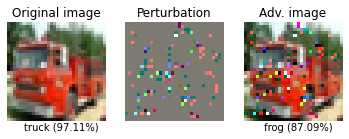

Number of iterations needed:  11
Number of perturbed pixels:  158


In [15]:
image, label = next(iter(adv_loader))
test_method(densenet, device, image, label, method='sparsefool', params=params_sparsefool)

**Perform a complete attack and show results**

In [0]:
#params = {'target_label': None, 'iters': 10, 'pop_size': 100, 'verbose': True}

adv_examples = attack_model(densenet, device, adv_loader, 'sparsefool', params_sparsefool, iters=2000)

 54%|█████▍    | 5397/10000 [5:22:36<5:02:21,  3.94s/it]

In [0]:
v = universal_perturbation(univ_loader, iv3, device, delta=0.1)

plt.imshow(denormalize_cifar10(v[0].cpu().detach().numpy()).transpose((1,2,0)))
plt.title('Universal perturbation')
plt.show()

In [0]:
image = Image.open('./data/img1.png')
x = TF.to_tensor(image)
x = normalize_cifar10(x)
x = x.unsqueeze_(0).to(device)
label = torch.tensor([1]).to(device)
print('Label:', label.item())
x.requires_grad = True
y = iv3(x)
init_pred = y.max(1, keepdim=True)[1]
print("Original image prediction: ", init_pred.item())
x_r = x.add(v).to(device)
pred = iv3(x_r).max(1, keepdim=True)[1]
print("Perturbed image prediction: ", pred.item())

Label: 1
Original image prediction:  1
Perturbed image prediction:  2


In [0]:
img, label = next(iter(adv_loader))
im = denormalize_cifar10(img.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()
label = label.item()
success, sol, score = one_pixel_attack(iv3, device, img, label, pop_size=400, iters=20)
print(success)
print(score)
adv = perturb(sol, img)
im = denormalize_cifar10(adv.numpy()[0].copy()).transpose((1,2,0))
plt.imshow(im)
plt.show()

In [0]:
def test_method(model, device, img, label, method, params):

  img = img.clone()

  model = model.to(device).eval()

  x = img.to(device)
  label = label.to(device)

  x.requires_grad = True

  y = model(x)
  init_pred = y.max(1, keepdim=True)[1]
  x_conf = F.softmax(y, dim=1).max(1, keepdim=True)[0].item()  

  if init_pred.item() != label.item():
    print("Wrong classification...")
    return

  # Call method
  if method == 'fgsm':
    adv_x, pert_x = fgsm(model, x, label, y, params["epsilon"], params["clip"])

  elif method == 'deepfool':
    _, adv_x, pert_x, n_iter = deepfool(model, device, x, params["num_classes"], overshoot=params["overshoot"], max_iter=params["max_iter"], p=params["p"], clip=params["clip"])

  elif method == 'sparsefool':
    # Generate lower and upper bounds
    delta = params["delta"]
    lb, ub =  valid_bounds(x, delta, dataset='cifar10')
    lb = lb[None, :, :, :].to(device)
    ub = ub[None, :, :, :].to(device)
    adv_x, pert_x, n_iter = sparsefool(model, device, x, label.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])

  elif method == 'one_pixel_attack':
    _, best_sol, score = one_pixel_attack(model, device, data, target.item(), params["target_label"], params["iters"], params["pop_size"], params["verbose"])
    adv_x = perturb(best_sol, data)

  y_adv = model(adv_x)
  adv_pred = y_adv.max(1, keepdim=True)[1]
  adv_x_conf = F.softmax(y_adv, dim=1).max(1, keepdim=True)[0].item()  

  if adv_pred.item() == label.item():
    print("Attack failed...")

  else:
    print("Succesful attack!")

  f = plt.figure()
  f.add_subplot(1,3,1)
  plt.title('Original image')
  plt.axis('off')
  f.text(.25, .3, cifar10_classes[label.item()] + ' ({:.2f}%)'.format(x_conf*100), ha='center')
  plt.imshow(displayable(img))
  f.add_subplot(1,3,2)
  plt.title('Perturbation')
  plt.axis('off')
  plt.imshow(displayable(pert_x.cpu().detach()))
  f.add_subplot(1,3,3)
  plt.title('Adv. image')
  plt.axis('off')
  f.text(.8, .3, cifar10_classes[adv_pred.item()] + ' ({:.2f}%)'.format(adv_x_conf*100), ha='center')
  plt.imshow(displayable(adv_x.cpu().detach()))
  plt.show(block=True)

  if method in ['deepfool',  'sparsefool']:
    print('Number of iterations needed: ', n_iter)

  if method == 'sparsefool':
    pert_pixels = pert_x.flatten().nonzero().size(0)
    print('Number of perturbed pixels: ', pert_pixels) 

In [0]:
def attack_model(model, device, test_loader, method, params, p=2, iters=10000, dataset='cifar10'):

  # Initialize the network and set the model in evaluation mode.
  model = model.to(device).eval()

  # Initialize stat counters
  correct = 0
  incorrect = 0
  confidence = 0
  total_time = 0
  ex_robustness = 0
  model_robustness = 0
  method_iters = 0
  n_pert_pixels = []
  adv_examples = []

  i = 0

  # Loop (iters) examples in test set
  for data, target in pbar(test_loader):
    if i >= iters:
      break
    i += 1

    # Send the data and label to the device
    data, target = data.to(device), target.to(device)

    # Set requires_grad attribute of tensor (important for some attacks)
    if method in ['fgsm', 'deepfool', 'sparsefool']:
        data.requires_grad = True

    # Forward pass the data through the model
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

    # If the initial prediction is wrong, dont botter attacking
    if init_pred.item() != target.item():
      continue

    if method == 'fgsm':
        # Call FGSM attack
        time_ini = time.time()
        perturbed_data, _ = fgsm(model, data, target, output, params["epsilon"], params["clip"], dataset)
        time_end = time.time()
        total_time += time_end-time_ini

    elif method == 'deepfool':
        # Call DeepFool attack
        time_ini = time.time()
        _, perturbed_data, _, n_iter = deepfool(model, device, data, params["num_classes"], overshoot=params["overshoot"], max_iter=params["max_iter"], p=params["p"], clip=params["clip"])
        time_end = time.time()
        total_time += time_end-time_ini
        method_iters += n_iter

    elif method == 'sparsefool':
        # Generate lower and upper bounds
        delta = params["delta"]
        lb, ub =  valid_bounds(data, delta, dataset='cifar10')
        lb = lb[None, :, :, :].to(device)
        ub = ub[None, :, :, :].to(device)
        # Call SparseFool attack
        time_ini = time.time()
        perturbed_data, perturbation, n_iter = sparsefool(model, device, data, target.item(), lb, ub, params["lambda_"], params["max_iter"], params["epsilon"])
        time_end = time.time()
        total_time += time_end-time_ini
        method_iters += n_iter
        n_pert_pixels.append(perturbation.flatten().nonzero().size(0))

    elif method == 'one_pixel_attack':
        # Call one pixel attack
        time_ini = time.time()
        _, best_sol, score = one_pixel_attack(model, device, data, target.item(), params["target_label"], params["iters"], params["pop_size"], params["verbose"])
        perturbed_data = perturb(best_sol, data)
        time_end = time.time()
        total_time += time_end-time_ini


    # Update model robustness
    # multiply by std to make it independent of the normalization used
    difference = de_scale(perturbed_data-data, dataset)
    if p == 2:
      adv_rob = torch.norm(difference)  # Frobenius norm (p=2)
      model_robustness += adv_rob / torch.norm(de_scale(data, dataset))
    elif p == np.inf:
      adv_rob = torch.norm(difference, float('inf'))  # Inf norm (p=inf)
      model_robustness += adv_rob / torch.norm(de_scale(data, dataset), float('inf'))
    ex_robustness += adv_rob
    
    # Re-classify the perturbed image
    output = model(perturbed_data)

    # Check for success
    final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    if final_pred.item() == target.item():
      correct += 1
    
    else:
      incorrect += 1
      # Update average confidence
      confidence += F.softmax(output, dim=1).max(1, keepdim=True)[0].item()  
      # Save some adv examples for visualization later
      if len(adv_examples) < 5:
        adv_examples.append( (init_pred.item(), final_pred.item(), data.detach().cpu(), perturbed_data.detach().cpu()) )

  # Calculate stats
  final_acc = correct / float(iters)  # len(test_loader)
  avg_confidence = confidence / float(incorrect)
  avg_time = total_time / float(correct+incorrect)
  avg_ex_robustness = ex_robustness / float(correct+incorrect)
  model_robustness = model_robustness / float(correct+incorrect)
  print("\n======== RESULTS ========")
  print("Test Accuracy = {} / {} = {:.4f}\nAverage confidence = {:.4f}\nAverage time = {:.4f}\nAverage magnitude of perturbations = {:.4f}\nModel robustness = {:.4f}"
    .format(correct, iters, final_acc, avg_confidence, avg_time, avg_ex_robustness, model_robustness))

  if method in ['deepfool', 'sparsefool']:
    print("Avg. iters = {:.2f}".format(method_iters / float(correct+incorrect)))

  if method == 'sparsefool':
    print("Median num. of pixels perturbed = ", statistics.median(n_pert_pixels))
    print("Average num. of pixels perturbed = {:.2f}".format(statistics.mean(n_pert_pixels)))

  # Return adversarial examples
  return adv_examples